Improts

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam


Step 1. Load & inspect

In [ ]:
# Load dataset
df = pd.read_csv("kddcup.data_10_percent", header=None)

# Define columns (from kddcup.names)
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes',
    'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
    'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login',
    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
    'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
    'srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
    'dst_host_rerror_rate','dst_host_srv_rerror_rate','label'
]
df.columns = columns

print(df.shape)
df.head()


(494021, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
print("\nData types:\n", df.dtypes.value_counts())


Data types:
 int64      23
float64    15
object      4
Name: count, dtype: int64


 Step 2. Check duplicates & nulls

In [59]:
# Null values
print("Nulls per column:\n", df.isnull().sum().sort_values(ascending=False))

# Duplicates
duplicates = df.duplicated().sum()
print("Number of duplicates:", duplicates)

# Drop duplicates
df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)


Nulls per column:
 duration          0
src_bytes         0
dst_bytes         0
land              0
wrong_fragment    0
                 ..
flag_S1           0
flag_S2           0
flag_S3           0
flag_SF           0
flag_SH           0
Length: 120, dtype: int64
Number of duplicates: 0
Shape after removing duplicates: (145586, 120)


In [ ]:
# Unique attack classes
unique_classes = df['label'].unique()
print("Number of unique classes:", len(unique_classes))
print("Attack classes:\n", unique_classes)

# Distribution (counts per class)
print("\nClass distribution:\n", df['label'].value_counts())


Number of unique classes: 23
Attack classes:
 ['normal.' 'buffer_overflow.' 'loadmodule.' 'perl.' 'neptune.' 'smurf.'
 'guess_passwd.' 'pod.' 'teardrop.' 'portsweep.' 'ipsweep.' 'land.'
 'ftp_write.' 'back.' 'imap.' 'satan.' 'phf.' 'nmap.' 'multihop.'
 'warezmaster.' 'warezclient.' 'spy.' 'rootkit.']

Class distribution:
 label
normal.             87832
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: count, dtype: int64


Step 3. Target variable simplification

In [ ]:
# Attack category mapping
attack_map = {
    'normal.': 'Normal',

    # DoS
    'back.':'DoS','land.':'DoS','neptune.':'DoS','pod.':'DoS','smurf.':'DoS','teardrop.':'DoS',

    # Probe
    'satan.':'Probe','ipsweep.':'Probe','nmap.':'Probe','portsweep.':'Probe',

    # R2L
    'ftp_write.':'R2L','guess_passwd.':'R2L','imap.':'R2L','multihop.':'R2L','phf.':'R2L',
    'spy.':'R2L','warezclient.':'R2L','warezmaster.':'R2L',

    # U2R
    'buffer_overflow.':'U2R','loadmodule.':'U2R','perl.':'U2R','rootkit.':'U2R'
}

df['attack_category'] = df['label'].map(attack_map)
print(df['attack_category'].value_counts())


attack_category
Normal    87832
DoS       54572
Probe      2131
R2L         999
U2R          52
Name: count, dtype: int64


Step 4. Encode categorical features

In [ ]:
# Categorical columns
cat_cols = ['protocol_type','service','flag']

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=cat_cols, dtype=int)

print("Shape before encoding:", df.shape)
print("Shape after encoding:", df.shape)

# Check first few rows
df.head()

Shape before encoding: (145586, 120)
Shape after encoding: (145586, 120)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,181,5450,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,239,486,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,235,1337,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,219,1337,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,217,2032,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


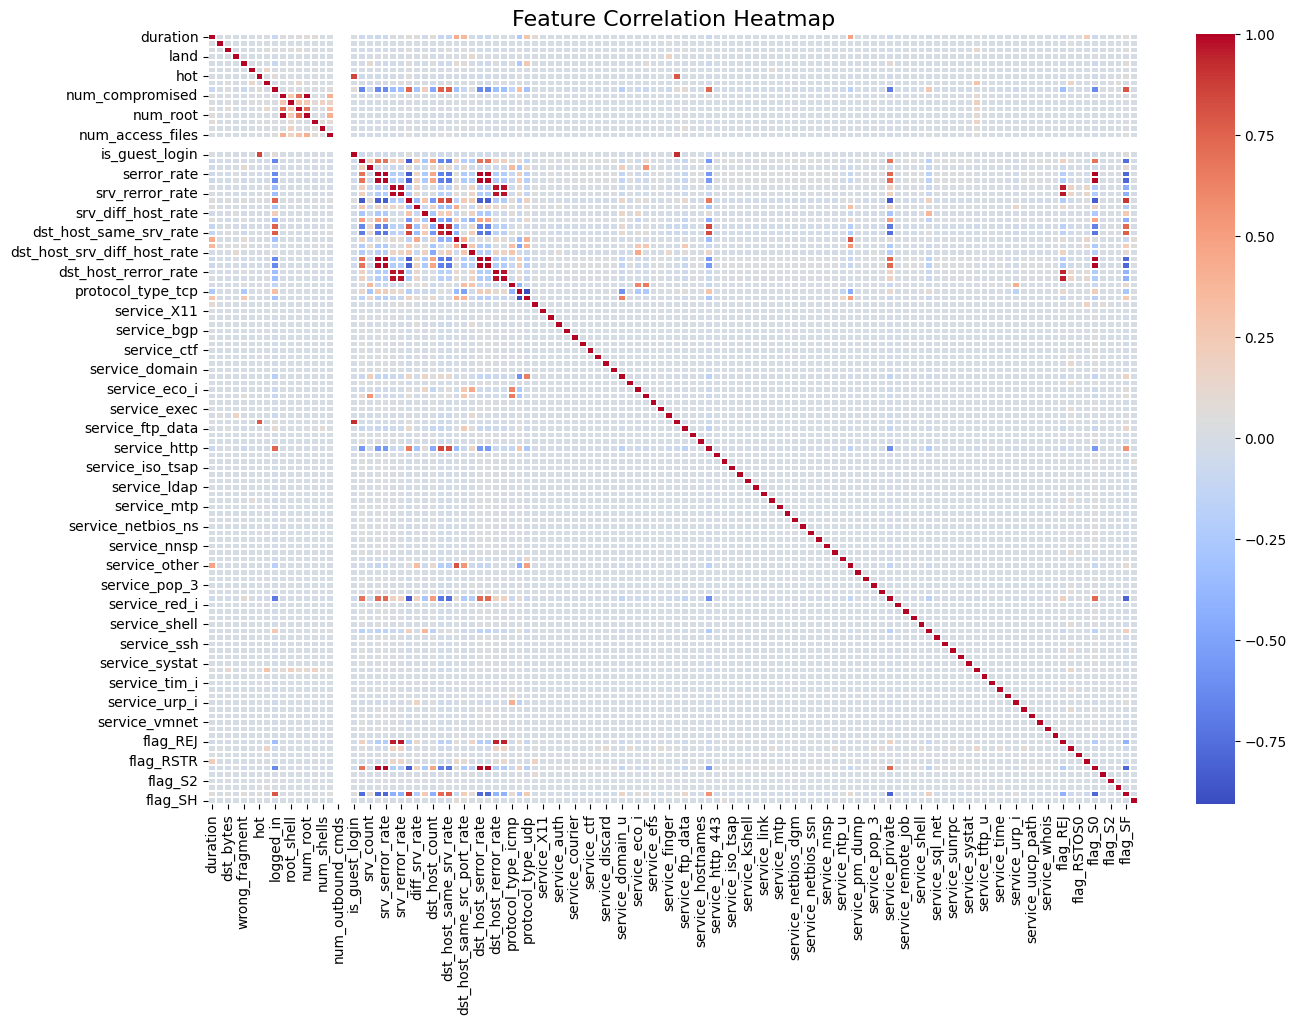

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix (on encoded data, excluding target columns)
corr = df.drop(['label','attack_category'], axis=1).corr()

# Plot heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr, cmap="coolwarm", linewidths=0.1, cbar=True)

plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()


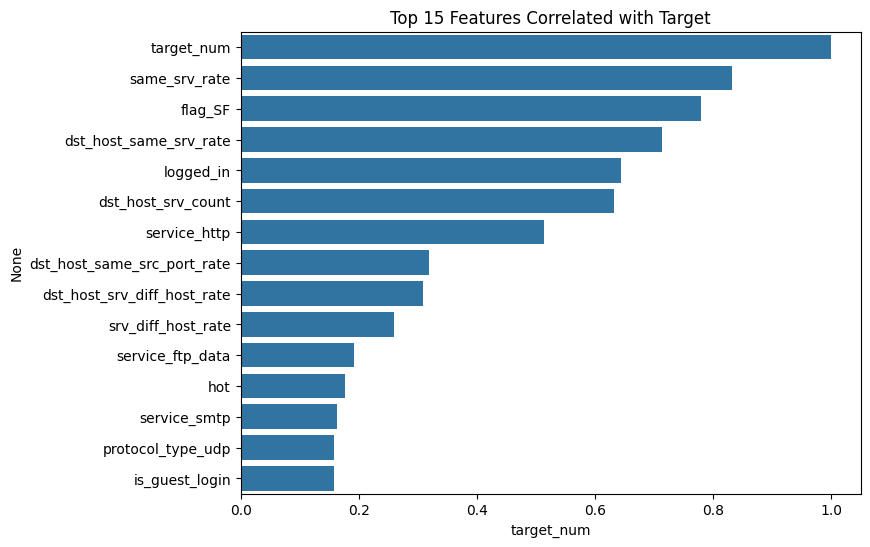

In [ ]:
# Encode target numerically just for correlation
y_numeric = df['attack_category'].astype('category').cat.codes

# Add to df temporarily
df_corr = df.copy()
df_corr['target_num'] = y_numeric

# Correlation with target only
corr_with_target = df_corr.corr(numeric_only=True)['target_num'].sort_values(ascending=False)

# Plot top 15
plt.figure(figsize=(8,6))
sns.barplot(x=corr_with_target.head(15), y=corr_with_target.head(15).index)
plt.title("Top 15 Features Correlated with Target")
plt.show()


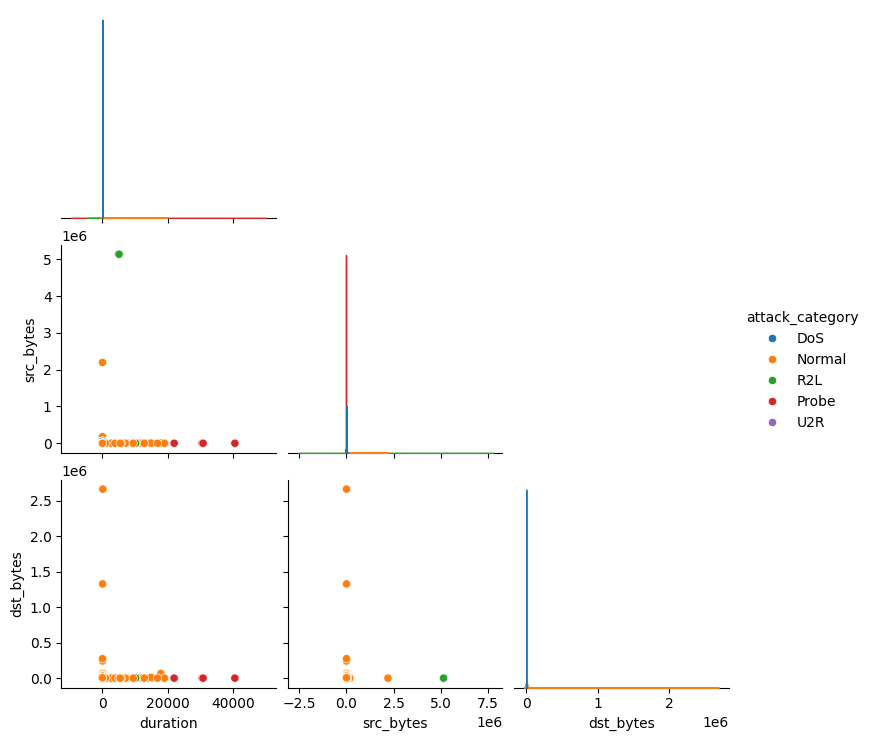

In [57]:
numeric_features = ['duration', 'src_bytes', 'dst_bytes']
sample_df = df.sample(5000, random_state=42)  # take 5000 rows
sns.pairplot(sample_df[numeric_features + ['attack_category']], hue='attack_category', diag_kind='kde', corner=True)
plt.show()


 Step 5. scale





In [ ]:
# Split into features and target
X = df.drop(['label', 'attack_category'], axis=1)
y = df['attack_category']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Scale training and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Step 6. Handle imbalance

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE on scaled training set
smote = SMOTE(random_state=42)
X_train_res_scaled, y_train_res = smote.fit_resample(X_train_scaled, y_train)


# Random **Forrest**

Random Forest Training Accuracy: 0.9999971536326763
Random Forest Test Accuracy: 0.9995535407651625

Classification Report (Test Data):
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     10915
      Normal       1.00      1.00      1.00     17567
       Probe       1.00      0.99      0.99       426
         R2L       0.99      0.98      0.98       200
         U2R       1.00      0.90      0.95        10

    accuracy                           1.00     29118
   macro avg       1.00      0.97      0.98     29118
weighted avg       1.00      1.00      1.00     29118



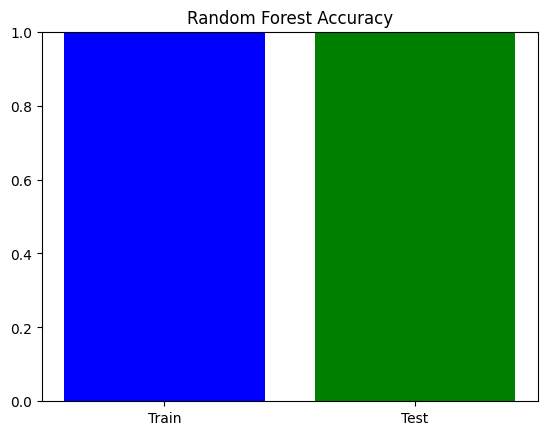

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res_scaled, y_train_res)

# Predictions
y_train_pred = rf.predict(X_train_res_scaled)
y_test_pred = rf.predict(X_test_scaled)

# Evaluation
print("Random Forest Training Accuracy:", accuracy_score(y_train_res, y_train_pred))
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred))

# Plot train vs test accuracy

import matplotlib.pyplot as plt

train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

plt.bar(["Train", "Test"], [train_acc, test_acc], color=["blue", "green"])
plt.title("Random Forest Accuracy")
plt.ylim(0, 1)
plt.show()

# Decision Tree

Decision Tree Training Accuracy: 0.9999971536326763
Decision Tree Test Accuracy: 0.9988666804038739

Classification Report (Test Data):
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     10915
      Normal       1.00      1.00      1.00     17567
       Probe       0.97      0.99      0.98       426
         R2L       0.96      0.98      0.97       200
         U2R       0.62      1.00      0.77        10

    accuracy                           1.00     29118
   macro avg       0.91      0.99      0.94     29118
weighted avg       1.00      1.00      1.00     29118



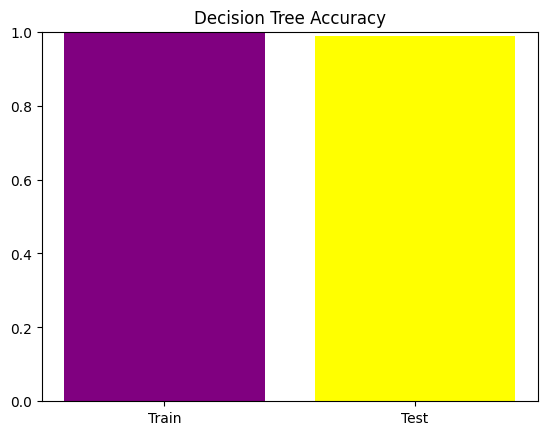

In [ ]:
# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_res_scaled, y_train_res)

# Predictions
y_train_pred = dt.predict(X_train_res_scaled)
y_test_pred = dt.predict(X_test_scaled)

# Evaluation
from sklearn.metrics import classification_report # Import classification_report
print("Decision Tree Training Accuracy:", accuracy_score(y_train_res, y_train_pred))
print("Decision Tree Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred))

# Plot train vs test accuracy
train_acc = accuracy_score(y_train_res, y_train_pred)


plt.bar(["Train", "Test"], [train_acc, test_acc], color=["purple", "yellow"])
plt.title("Decision Tree Accuracy")
plt.ylim(0, 1)
plt.show()

# Neural **Network**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.9441 - loss: 0.1923 - val_accuracy: 0.9884 - val_loss: 0.0464
Epoch 2/20
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9925 - loss: 0.0309 - val_accuracy: 0.9927 - val_loss: 0.0389
Epoch 3/20
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9951 - loss: 0.0209 - val_accuracy: 0.9942 - val_loss: 0.0287
Epoch 4/20
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9959 - loss: 0.0191 - val_accuracy: 0.9922 - val_loss: 0.0360
Epoch 5/20
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9962 - loss: 0.0170 - val_accuracy: 0.9915 - val_loss: 0.0422
Epoch 6/20
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9965 - loss: 0.0145 - val_accuracy: 0.9966 - val_loss: 0.0393
Epoch 7/20
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9968 - loss: 0.0200 - val_accuracy: 0.9965 - val_loss: 0.0288
Epoch 8/20
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9971 -

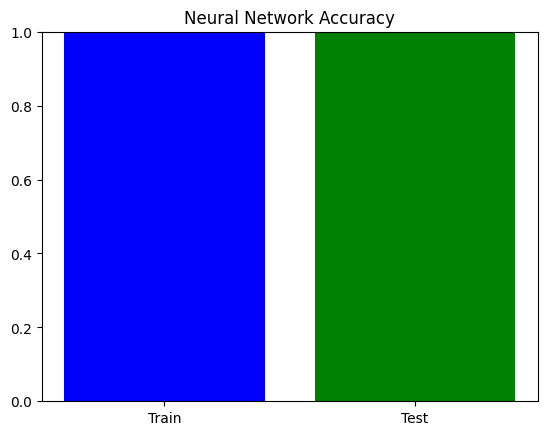

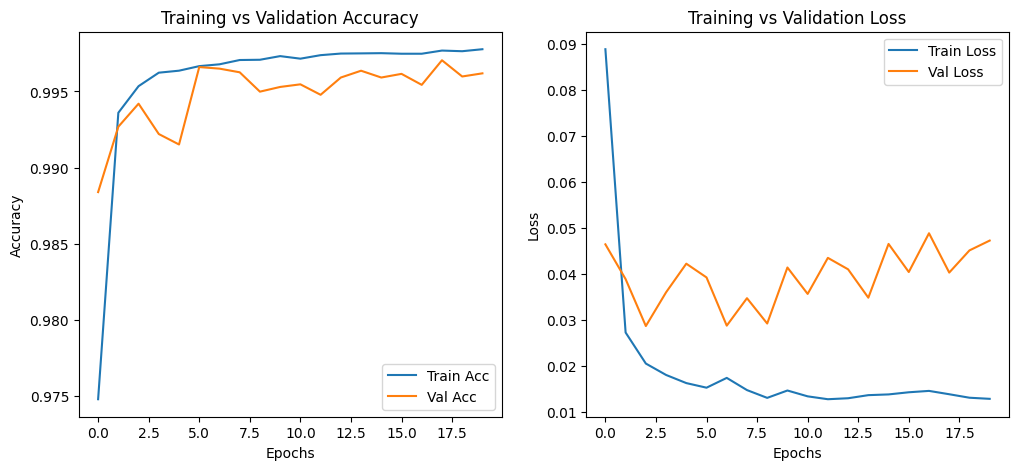

In [ ]:
# === One-hot encode the labels ===

encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train_res.values.reshape(-1, 1)).toarray()
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).toarray()

num_classes = y_train_encoded.shape[1]

# === Neural Network Model ===
model = Sequential([
    Dense(units=256, input_shape=(X_train_res_scaled.shape[1],)),
    ReLU(),
    Dropout(0.5),
    Dense(units=512),
    LeakyReLU(),
    Dropout(0.5),
    Dense(units=num_classes, activation="softmax")
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

# === Training ===
history = model.fit(
    X_train_res_scaled, y_train_encoded,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_scaled, y_test_encoded),
    verbose=1
)

# === Predictions ===
y_train_pred = np.argmax(model.predict(X_train_res_scaled), axis=-1)
y_test_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

# === Evaluation ===
train_acc = accuracy_score(np.argmax(y_train_encoded, axis=-1), y_train_pred)
test_acc = accuracy_score(np.argmax(y_test_encoded, axis=-1), y_test_pred)

print("Neural Network Training Accuracy:", train_acc)
print("Neural Network Test Accuracy:", test_acc)
print("\nClassification Report (Test Data):\n", classification_report(np.argmax(y_test_encoded, axis=-1), y_test_pred))

# === Accuracy Plot (Train vs Test) ===
plt.bar(["Train", "Test"], [train_acc, test_acc], color=["blue", "green"])
plt.title("Neural Network Accuracy")
plt.ylim(0, 1)
plt.show()

# === Training Curves (Loss & Accuracy) ===
plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# **KNN**

KNN Training Accuracy: 0.9995417348608838
KNN Test Accuracy: 0.997183872518717

Classification Report (Test Data):
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     10915
      Normal       1.00      1.00      1.00     17567
       Probe       0.97      0.97      0.97       426
         R2L       0.84      0.99      0.91       200
         U2R       0.67      0.80      0.73        10

    accuracy                           1.00     29118
   macro avg       0.90      0.95      0.92     29118
weighted avg       1.00      1.00      1.00     29118



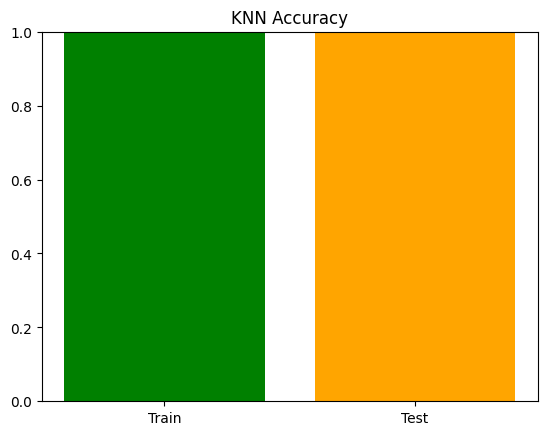

In [ ]:
# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_res_scaled, y_train_res)

# Predictions
y_train_pred = knn.predict(X_train_res_scaled)
y_test_pred = knn.predict(X_test_scaled)

# Evaluation
print("KNN Training Accuracy:", accuracy_score(y_train_res, y_train_pred))
print("KNN Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred))

# Plot train vs test accuracy
train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

plt.bar(["Train", "Test"], [train_acc, test_acc], color=["green", "orange"])
plt.title("KNN Accuracy")
plt.ylim(0, 1)
plt.show()

# Logistic Regression

Logistic Regression Training Accuracy: 0.9936668327047605
Logistic Regression Test Accuracy: 0.9889415481832543

Classification Report (Test Data):
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     10915
      Normal       1.00      0.98      0.99     17567
       Probe       0.86      0.97      0.91       426
         R2L       0.52      0.97      0.68       200
         U2R       0.14      0.70      0.23        10

    accuracy                           0.99     29118
   macro avg       0.70      0.92      0.76     29118
weighted avg       0.99      0.99      0.99     29118



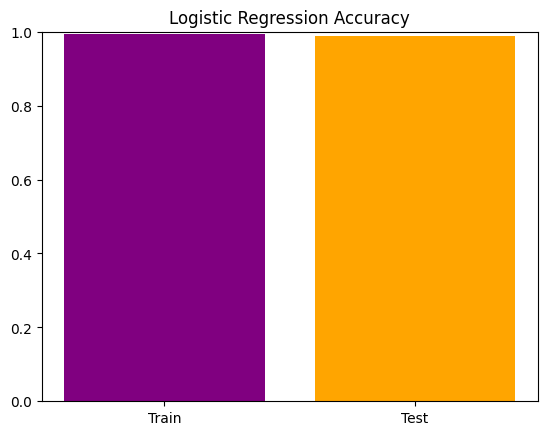

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_res_scaled, y_train_res)

# Predictions
y_train_pred = log_reg.predict(X_train_res_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Evaluation
print("Logistic Regression Training Accuracy:", accuracy_score(y_train_res, y_train_pred))
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred))


# Plot train vs test accuracy


train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

plt.bar(["Train", "Test"], [train_acc, test_acc], color=["purple", "orange"])
plt.title("Logistic Regression Accuracy")
plt.ylim(0, 1)
plt.show()

# **SVM**

SVM Training Accuracy: 0.9890215612324771
SVM Test Accuracy: 0.9875334844426128

Classification Report (Test Data):
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     10915
      Normal       1.00      0.98      0.99     17567
       Probe       0.90      0.97      0.93       426
         R2L       0.43      0.96      0.60       200
         U2R       0.19      0.70      0.30        10

    accuracy                           0.99     29118
   macro avg       0.70      0.92      0.76     29118
weighted avg       0.99      0.99      0.99     29118



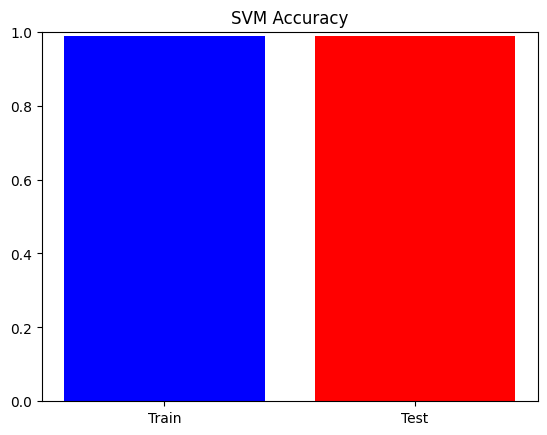

In [51]:
# Train SVM
svm = SVC(kernel="rbf", random_state=42)
svm.fit(X_train_res_scaled, y_train_res)

# Predictions
y_train_pred = svm.predict(X_train_res_scaled)
y_test_pred = svm.predict(X_test_scaled)

# Evaluation
print("SVM Training Accuracy:", accuracy_score(y_train_res, y_train_pred))
print("SVM Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred))

# Plot train vs test accuracy
train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

plt.bar(["Train", "Test"], [train_acc, test_acc], color=["blue", "red"])
plt.title("SVM Accuracy")
plt.ylim(0, 1)
plt.show()

# Naive **Bayes**

Naïve Bayes Training Accuracy: 0.6959481961147086
Naïve Bayes Test Accuracy: 0.6312933580603063

Classification Report (Test Data):
               precision    recall  f1-score   support

         DoS       0.97      0.13      0.24     10915
      Normal       0.98      0.94      0.96     17567
       Probe       0.04      0.86      0.07       426
         R2L       0.24      0.47      0.32       200
         U2R       0.01      0.90      0.02        10

    accuracy                           0.63     29118
   macro avg       0.45      0.66      0.32     29118
weighted avg       0.96      0.63      0.67     29118



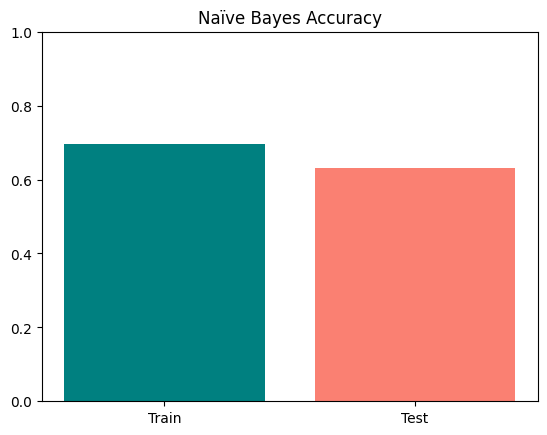

In [ ]:

# Train Naïve Bayes
nb = GaussianNB()
nb.fit(X_train_res_scaled, y_train_res)

# Predictions
y_train_pred = nb.predict(X_train_res_scaled)
y_test_pred = nb.predict(X_test_scaled)

# Evaluation
print("Naïve Bayes Training Accuracy:", accuracy_score(y_train_res, y_train_pred))
print("Naïve Bayes Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred))

# Plot train vs test accuracy

import matplotlib.pyplot as plt

train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

plt.bar(["Train", "Test"], [train_acc, test_acc], color=["teal", "salmon"])
plt.title("Naïve Bayes Accuracy")
plt.ylim(0, 1)
plt.show()